# La Silla Analysis

Status: Done

Remark: All the analysis is going to be aggregating all the data by hour, so doing it in that way, we can analyse all the years together and compare them

In [48]:
# packages 
import pandas as pd
import numpy as np
from pymongo import MongoClient
import missingno as msno 

import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns
sns.set_theme(style="ticks")


In [2]:
## connecting
db_name = "meteo_lasilla"
client = MongoClient("mongodb://localhost:27017/")
db = client[db_name] # meteo_paranal_test
collection = db[db_name]

## Counting Samples

In [3]:
print('Expected samples per year: ', 60*24*365) # asuming that we have un sample per minute

Expected samples per year:  525600


In [4]:

## samples per year
pipeline = [
    {   # it extracts the year from Date time
        "$project": { "year": {"$year": {"$dateFromString": {"dateString": "$Date time"}}},}},
    { "$group": {"_id": "$year",# grouping by year and sum per sample 
                "count": {"$sum": 1}}},
    {"$sort": {"_id": 1}  # sort by year in ascending order
    }
]
result = list(collection.aggregate(pipeline))
for result_it in result:
    print(f"Year: {result_it['_id']}, Count: {result_it['count']}")

Year: 1991, Count: 2
Year: 1993, Count: 1935
Year: 1994, Count: 159651
Year: 1995, Count: 152038
Year: 1996, Count: 164892
Year: 1997, Count: 230500
Year: 1998, Count: 369322
Year: 1999, Count: 449286
Year: 2000, Count: 426784
Year: 2001, Count: 255628
Year: 2002, Count: 256237
Year: 2003, Count: 258165
Year: 2004, Count: 255047
Year: 2005, Count: 254790
Year: 2006, Count: 255003
Year: 2007, Count: 258633
Year: 2008, Count: 158175
Year: 2010, Count: 256111
Year: 2011, Count: 496978
Year: 2012, Count: 499619
Year: 2013, Count: 502408
Year: 2014, Count: 320822
Year: 2015, Count: 412360
Year: 2016, Count: 447534
Year: 2017, Count: 502776
Year: 2018, Count: 482943
Year: 2019, Count: 505830
Year: 2020, Count: 408280
Year: 2021, Count: 476174
Year: 2022, Count: 449252
Year: 2023, Count: 387030
Year: 2024, Count: 28100


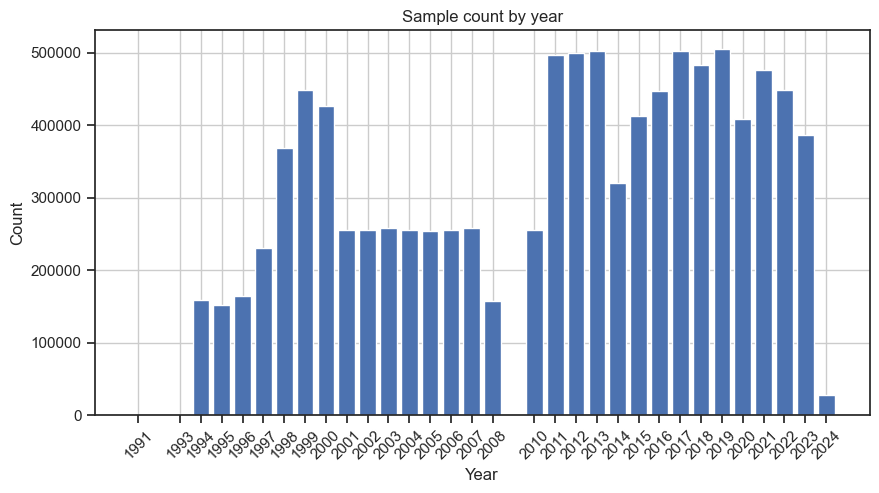

In [5]:
years = [result_it['_id'] for result_it in result]
counts = [result_it['count'] for result_it in result]

fig, ax = plt.subplots(figsize=(10,5))
plt.bar(years, counts)
plt.xticks(years,rotation=45)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Sample count by year')
plt.grid(True)
plt.show()

all of these years has missing values in a big ranges, we expected to have 500k samples but only a few of them are close

In [6]:
## utils (skip this cell)
numeric_col = [
'Air Pressure at 2m [hPa]', 
'Air Pressure Normalised [hPa]', 
'Ambient Temperature at 30m [C]', 
'Ambient Temperature at 2m [C]', 
'Ambient Temperature at ground [C]', 
'Dew Temperature at 2m [C]', 
'Relative Humidity at 2m [%]', 
'Wind Direction at 30m [deg]', 
'Wind Direction at 10m [deg]', 
'Wind Speed at 30m [m/s]', 
'Wind Speed at 10m [m/s]'
 ]

def dict_to_datetime(x):
   return f"{x['year']}-{x['month']}-{x['day']} {x['hour']}:00:00"


def get_datetime_index(df):
    df['_id'] = pd.to_datetime(df['_id'].apply(dict_to_datetime))
    df = df.set_index(['_id'])
    df = df.sort_index(ascending=True)
    return df

def get_df(aggregated_expression):

    pipeline = [
        {"$group": {
                "_id": {
                    "year": {"$year": {"$dateFromString": {"dateString": "$Date time"}}},
                    "month": {"$month": {"$dateFromString": {"dateString": "$Date time"}}},
                    "day": {"$dayOfMonth": {"$dateFromString": {"dateString": "$Date time"}}},
                    "hour": {"$hour": {"$dateFromString": {"dateString": "$Date time"}}},
                }, 
                **aggregated_expression}},
        {"$sort": {"_id.year": 1, "_id.month": 1, "_id.day": 1, "_id.hour": 1} }
    ]

    result = list(collection.aggregate(pipeline))

    return pd.DataFrame(result)



Remark: that pipeline calculate the average per period only in the numeric values. Nan values are not be considered:
https://www.mongodb.com/docs/manual/reference/operator/aggregation/avg/

In [7]:
## uploading data

# defining what we want
mean_agg = {f: {"$avg": f"${f}"} for f in numeric_col}
std_agg = {f: {"$stdDevSamp": f"${f}"} for f in numeric_col}
# min_agg = {f: {"$min": f"${f}"} for f in numeric_col}
# max_agg = {f: {"$max": f"${f}"} for f in numeric_col}

# getting df
df_mean = get_df(mean_agg)
df_std = get_df(std_agg)
# df_min = get_df(min_agg)
# df_max = get_df(max_agg)

# getting datetime index sorted
df_mean = get_datetime_index(df_mean)
df_std = get_datetime_index(df_std)
# df_min = get_datetime_index(df_min)
# df_max = get_datetime_index(df_max)


In [20]:
df=df_mean.copy() # just for save
print('DF shape: ',df.shape)
display(df.head(3))

DF shape:  (229363, 11)


Air Pressure at 2m [hPa]  Air Pressure Normalised [hPa]  \
_id                                                                            
1991-04-01 00:00:00                     772.4                            NaN   
1991-04-01 01:00:00                       0.0                            NaN   
1993-02-02 03:00:00                       0.0                            NaN   

                     Ambient Temperature at 30m [C]  \
_id                                                   
1991-04-01 00:00:00                             NaN   
1991-04-01 01:00:00                             NaN   
1993-02-02 03:00:00                             0.0   

                     Ambient Temperature at 2m [C]  \
_id                                                  
1991-04-01 00:00:00                            0.0   
1991-04-01 01:00:00                            0.0   
1993-02-02 03:00:00                            0.0   

                     Ambient Temperature at ground [C]  \
_id                                                      
1991-04-01 00:00:00                               17.2   
1991-04-01 01:00:00                                NaN   
1993-02-02 03:00:00                                0.0   

                     Dew Temperature at 2m [C]  Relative Humidity at 2m [%]  \
_id                                                                           
1991-04-01 00:00:00                        NaN                          NaN   
1991-04-01 01:00:00                        NaN                          NaN   
1993-02-02 03:00:00                        NaN                          0.0   

                     Wind Direction at 30m [deg]  Wind Direction at 10m [deg]  \
_id                                                                             
1991-04-01 00:00:00                        163.0                          NaN   
1991-04-01 01:00:00                         97.0                          NaN   
1993-02-02 03:00:00                          NaN                          NaN   

                     Wind Speed at 30m [m/s]  Wind Speed at 10m [m/s]  
_id                                                                    
1991-04-01 00:00:00                      2.9                      3.3  
1991-04-01 01:00:00                      0.0                      0.0  
1993-02-02 03:00:00                      0.0                      0.0

In [21]:
df.info()
# df.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 229363 entries, 1991-04-01 00:00:00 to 2024-01-21 16:00:00
Data columns (total 11 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Air Pressure at 2m [hPa]           229350 non-null  float64
 1   Air Pressure Normalised [hPa]      78281 non-null   float64
 2   Ambient Temperature at 30m [C]     176813 non-null  float64
 3   Ambient Temperature at 2m [C]      229284 non-null  float64
 4   Ambient Temperature at ground [C]  124000 non-null  float64
 5   Dew Temperature at 2m [C]          182812 non-null  float64
 6   Relative Humidity at 2m [%]        228362 non-null  float64
 7   Wind Direction at 30m [deg]        167268 non-null  float64
 8   Wind Direction at 10m [deg]        179111 non-null  float64
 9   Wind Speed at 30m [m/s]            165908 non-null  float64
 10  Wind Speed at 10m [m/s]            214885 non-null  float64
dtypes: fl

All the features are float64 format 

## Missing values Analysis

<Figure size 640x480 with 0 Axes>

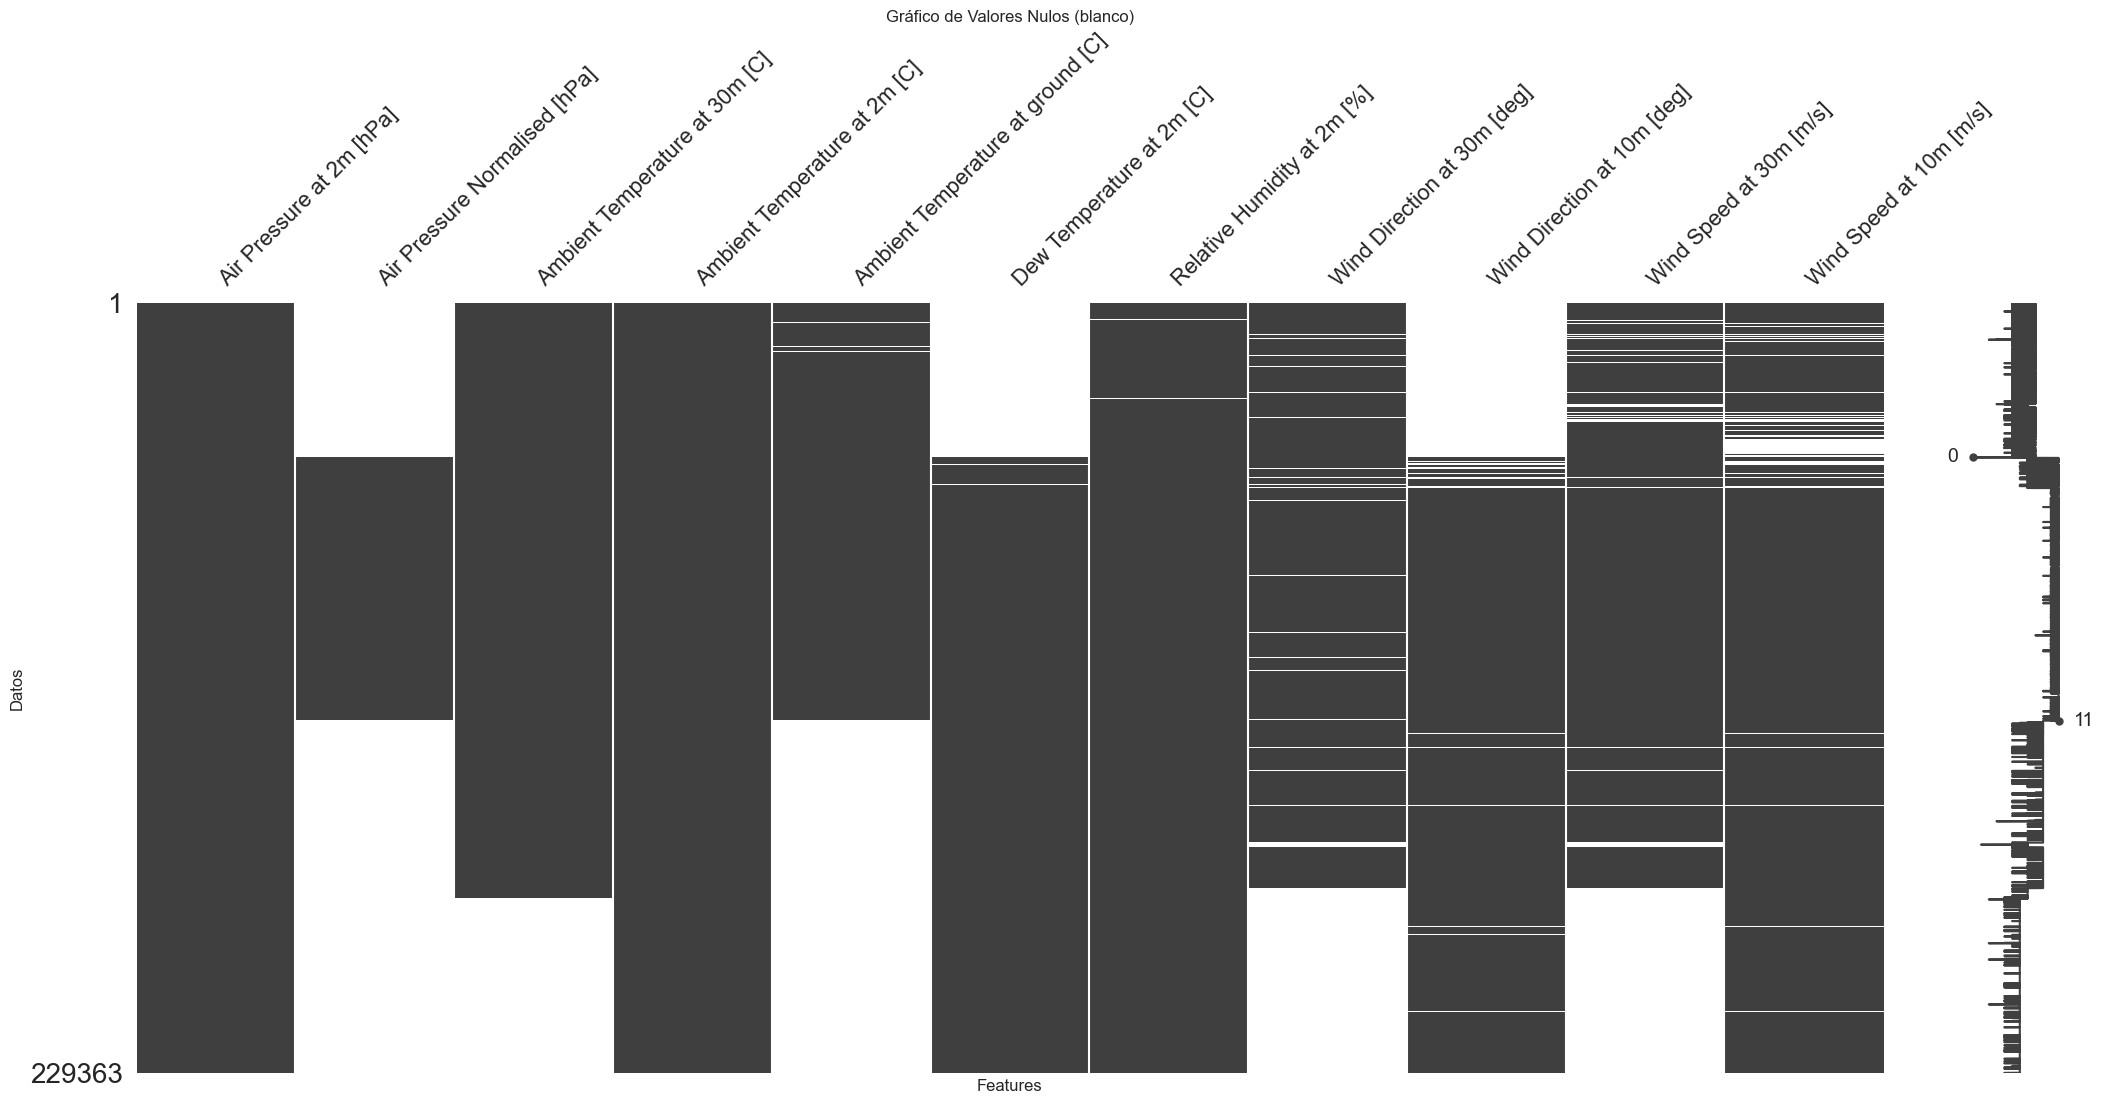

In [9]:
## general values of nan values
plt.clf()
msno.matrix(df)
plt.title('Gráfico de Valores Nulos (blanco)')
plt.xlabel('Features')
plt.ylabel('Datos')
plt.show()

here we have a lot of null values, and even in the lasts years some of them dissapear

In [10]:
df.isna().sum()

Air Pressure at 2m [hPa]                 13
Air Pressure Normalised [hPa]        151082
Ambient Temperature at 30m [C]        52550
Ambient Temperature at 2m [C]            79
Ambient Temperature at ground [C]    105363
Dew Temperature at 2m [C]             46551
Relative Humidity at 2m [%]            1001
Wind Direction at 30m [deg]           62095
Wind Direction at 10m [deg]           50252
Wind Speed at 30m [m/s]               63455
Wind Speed at 10m [m/s]               14478
dtype: int64

In [86]:
print('last record before nan values of ambient temperature at ground: ',df[df['Ambient Temperature at ground [C]'].notna()]['Ambient Temperature at ground [C]'].index[-1])

last record before nan values of ambient temperature at ground:  2008-08-16 20:00:00


In [17]:
print('first record of air pressure normalized: ',df[df['Air Pressure Normalised [hPa]'].notna()]['Air Pressure Normalised [hPa]'].index[0])

first record of air pressure normalized:  1999-07-05 09:00:00


this means we can use date range 2008-08-16 20:00:00 to 1999-07-05 09:00:00 and we will have almost all variables available at same time

let's check if definetly we don't have missing values in that range:

In [24]:
date_range = pd.date_range(start='1999-07-05 09:00:00', end='2008-08-16 20:00:00', freq='H')
df_timestamp = pd.DataFrame(index=date_range)
merged_df = pd.merge(df, df_timestamp, left_index=True, right_index=True, how='right')

/var/folders/b0/69vxpwp54bj58xqzl4ynkwbw0000gn/T/ipykernel_35309/2452515835.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start='1999-07-05 09:00:00', end='2008-08-16 20:00:00', freq='H')


<Figure size 640x480 with 0 Axes>

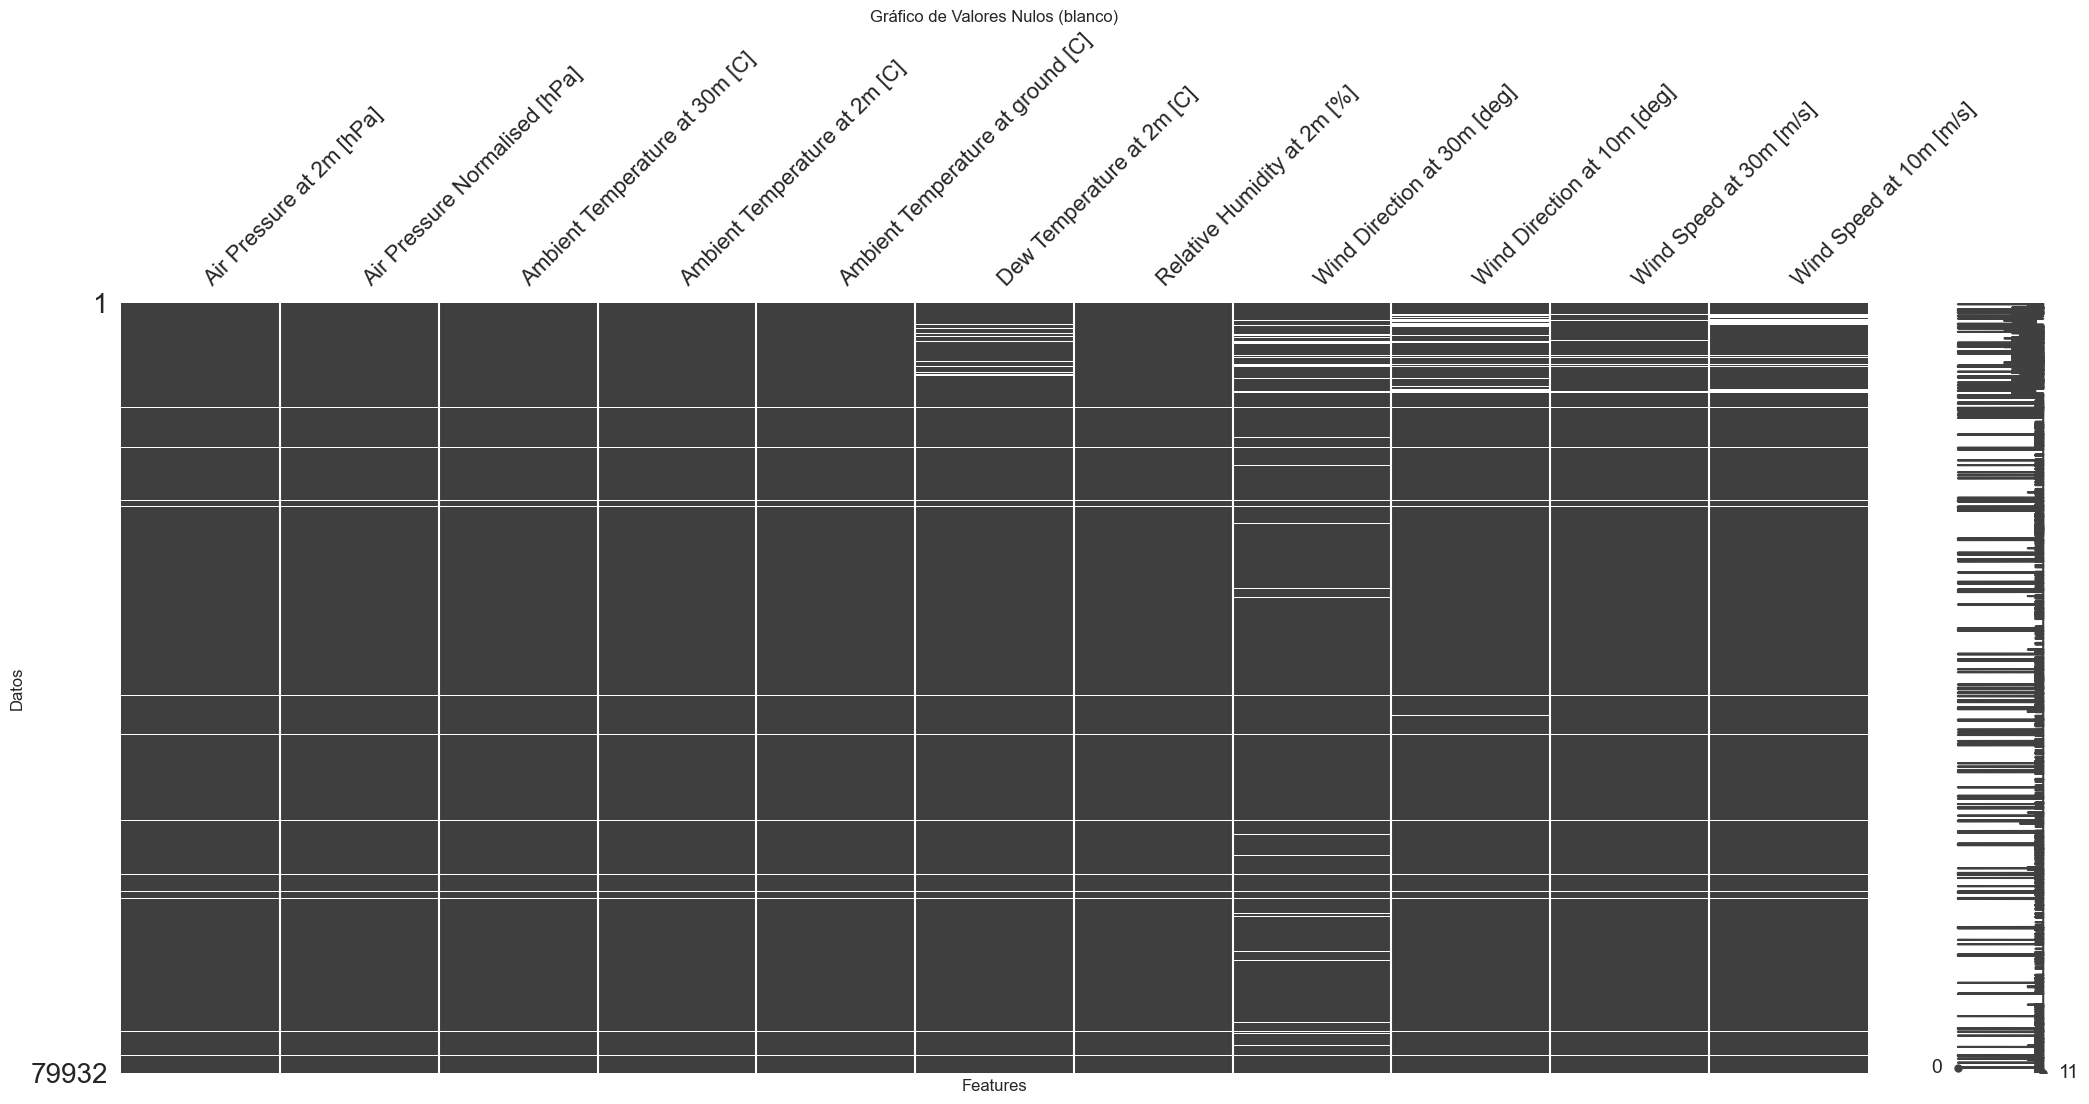

In [26]:
## general values of nan values
plt.clf()
msno.matrix(merged_df)
plt.title('Gráfico de Valores Nulos (blanco)')
plt.xlabel('Features')
plt.ylabel('Datos')
plt.show()

In [30]:
def get_null_intervals(merged_df,column='Air Pressure at 2m [hPa]'):
    m = merged_df[column].isna()
    r = [[*g.index] for _, g in merged_df[m].groupby((~m).cumsum())]
    intervals = [(a[0],a[-1]) for a in r]
    return pd.DataFrame([[a[0],a[1],(a[1]-a[0]).seconds/3600] for a in intervals],
                columns=['inicial','final','horas']).sort_values('horas',ascending=False).reset_index(drop=True)

Here we have intervals where we don't find values fot Air Pressure at 2m [hPa] (a variable which has few missing values)

In [32]:
df_intervals = get_null_intervals(merged_df,column='Air Pressure at 2m [hPa]')
df_intervals.head(20)

inicial               final  horas
0  1999-09-08 14:00:00 1999-09-09 11:00:00   21.0
1  2005-08-20 02:00:00 2005-08-20 22:00:00   20.0
2  2004-08-13 15:00:00 2004-08-14 11:00:00   20.0
3  2000-10-10 15:00:00 2000-10-11 11:00:00   20.0
4  2000-10-22 15:00:00 2000-10-23 11:00:00   20.0
5  2008-02-19 06:00:00 2008-02-20 01:00:00   19.0
6  2001-03-20 16:00:00 2001-03-21 11:00:00   19.0
7  2005-11-30 01:00:00 2005-11-30 19:00:00   18.0
8  2008-02-06 20:00:00 2008-02-08 13:00:00   17.0
9  2005-08-19 04:00:00 2005-08-19 21:00:00   17.0
10 2008-07-01 04:00:00 2008-07-01 21:00:00   17.0
11 2006-04-07 02:00:00 2006-04-08 18:00:00   16.0
12 2005-12-01 03:00:00 2005-12-01 19:00:00   16.0
13 2004-02-26 19:00:00 2004-02-29 11:00:00   16.0
14 2002-09-11 01:00:00 2002-09-11 17:00:00   16.0
15 2003-11-16 02:00:00 2003-11-16 17:00:00   15.0
16 2006-07-23 21:00:00 2006-07-24 11:00:00   14.0
17 2005-01-12 09:00:00 2005-01-12 23:00:00   14.0
18 2004-08-02 21:00:00 2004-08-03 11:00:00   14.0
19 2003-05-20 04:00:00 2003-05-20 18:00:00   14.0

so in this solid datetime range, we can see there are some ranges with null values of lenght of ~20 hrs.

let's see how it is our dataset in the range of '1999-07-05 09:00:00' to '2008-08-16 20:00:00'

In [41]:
df = df.loc['1999-07-05 09:00:00':'2008-08-16 20:00:00'] 

## Correlations

In [42]:
## correlation function
def get_principal_correlations(df_corr,n_display):

    upper_triangle_correlation = df_corr.where(np.triu(np.ones(df_corr.shape), k=1).astype(bool))
    top_positive_correlations = upper_triangle_correlation.unstack().sort_values(ascending=False)[:n_display]
    top_negative_correlations = upper_triangle_correlation.unstack().sort_values(ascending=True)[:n_display]

    rename_columns={'level_0':'feature1','level_1':'feature2',0:'Correlation'}

    less_correlated = upper_triangle_correlation.unstack().reset_index()
    less_correlated.rename(columns=rename_columns,inplace=True)
    less_correlated.Correlation=less_correlated.Correlation.apply(lambda x : abs(x))
    less_correlated= less_correlated.sort_values(by=['Correlation'],ascending=True)[less_correlated['Correlation']>0][:n_display]

    top_positive_correlations=top_positive_correlations.reset_index()
    top_positive_correlations.rename(columns=rename_columns,inplace=True)

    top_negative_correlations=top_negative_correlations.reset_index()
    top_negative_correlations.rename(columns=rename_columns,inplace=True)


    return top_negative_correlations,top_positive_correlations,less_correlated

In [43]:
top_negative_correlations,top_positive_correlations,less_correlated = get_principal_correlations(df.corr(),n_display=20)

/var/folders/b0/69vxpwp54bj58xqzl4ynkwbw0000gn/T/ipykernel_35309/678062977.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  less_correlated= less_correlated.sort_values(by=['Correlation'],ascending=True)[less_correlated['Correlation']>0][:n_display]


In [44]:
display(top_negative_correlations.iloc[:10])
display(top_positive_correlations.iloc[:10])

feature1                           feature2  Correlation
0      Wind Speed at 30m [m/s]           Air Pressure at 2m [hPa]    -0.492961
1      Wind Speed at 30m [m/s]      Ambient Temperature at 2m [C]    -0.461063
2      Wind Speed at 30m [m/s]     Ambient Temperature at 30m [C]    -0.453158
3      Wind Speed at 30m [m/s]  Ambient Temperature at ground [C]    -0.439949
4      Wind Speed at 30m [m/s]        Wind Direction at 30m [deg]    -0.435588
5      Wind Speed at 10m [m/s]           Air Pressure at 2m [hPa]    -0.416399
6      Wind Speed at 10m [m/s]        Wind Direction at 30m [deg]    -0.394549
7  Relative Humidity at 2m [%]     Ambient Temperature at 30m [C]    -0.378231
8      Wind Speed at 30m [m/s]      Air Pressure Normalised [hPa]    -0.373603
9      Wind Speed at 10m [m/s]      Ambient Temperature at 2m [C]    -0.365031

feature1                           feature2  \
0      Ambient Temperature at 2m [C]     Ambient Temperature at 30m [C]   
1            Wind Speed at 10m [m/s]            Wind Speed at 30m [m/s]   
2      Air Pressure Normalised [hPa]           Air Pressure at 2m [hPa]   
3        Relative Humidity at 2m [%]          Dew Temperature at 2m [C]   
4          Dew Temperature at 2m [C]  Ambient Temperature at ground [C]   
5        Wind Direction at 10m [deg]        Wind Direction at 30m [deg]   
6  Ambient Temperature at ground [C]      Ambient Temperature at 2m [C]   
7  Ambient Temperature at ground [C]     Ambient Temperature at 30m [C]   
8      Ambient Temperature at 2m [C]           Air Pressure at 2m [hPa]   
9     Ambient Temperature at 30m [C]           Air Pressure at 2m [hPa]   

   Correlation  
0     0.954913  
1     0.899278  
2     0.778814  
3     0.745977  
4     0.711486  
5     0.692233  
6     0.644995  
7     0.617622  
8     0.551104  
9     0.545927

Some interesting correlations are:
* Wind speed with ambient temperature
* Humidity with with dew temperature
* dew temperature with ambient temperature

# Plot Analysis

In [38]:
import holoviews as hv
from holoviews import opts
import hvplot.pandas

hv.extension('bokeh', 'matplotlib')

## Historic Histogram


In [45]:
# plot with holoviews for my information (they are not displayed in repo) 
def create_histogram(variable):
    return df.hvplot.hist(y=variable, bins=200, title=f'Histogram of {variable}')

variables_list = numeric_col
histogram_dmap = hv.DynamicMap(create_histogram, kdims=['variable']).redim.values(variable=variables_list)
layout = histogram_dmap.opts(framewise=True)
layout

BokehModel(combine_events=True, render_bundle={'docs_json': {'abf4e5c9-9230-48db-afee-d6eedd408750': {'version…

normal-like or log-normal-like
* Air Pressure at 2m [hPa]
* Air Pressure Normalised [hPa]
* Ambient Temperature at 30m [C]
* Ambient Temperature at 2m [C]
* Wind Speed at 30m [m/s]
* Wind Speed at 10m [m/s]

not normal like:
* Ambient Temperature at ground [C]
* Dew Temperature at 2m [C]

with two modal values 
* Relative Humidity at 2m [%]
* Wind Direction at 30m [deg]
* Wind Direction at 10m [deg]

Examples:

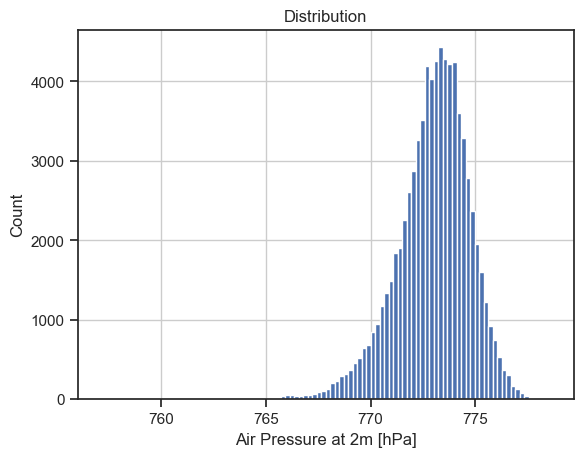

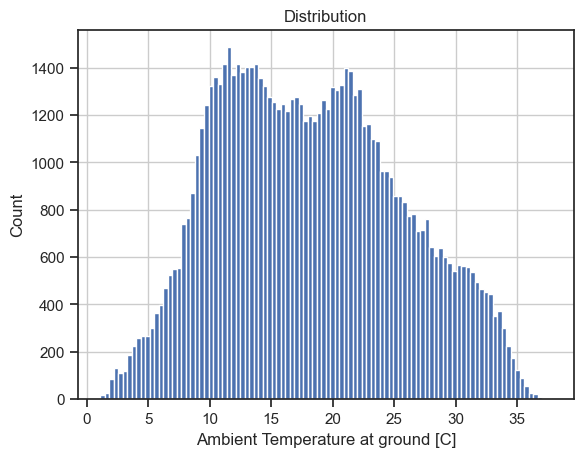

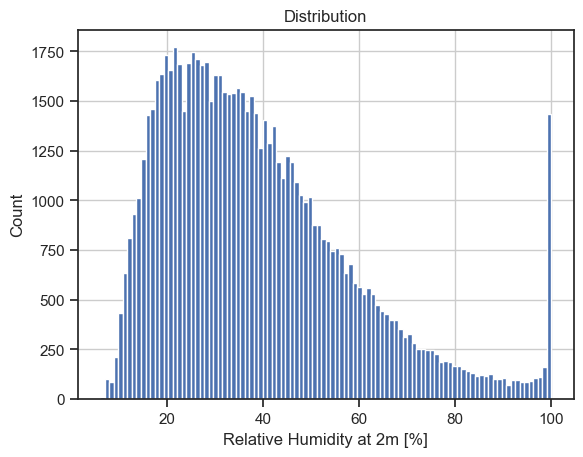

In [53]:
df['Air Pressure at 2m [hPa]'].hist(bins=100)
plt.xlabel('Air Pressure at 2m [hPa]')
plt.ylabel('Count')
plt.title('Distribution')
plt.show()
df['Ambient Temperature at ground [C]'].hist(bins=100)
plt.xlabel('Ambient Temperature at ground [C]')
plt.ylabel('Count')
plt.title('Distribution')
plt.show()
df['Relative Humidity at 2m [%]'].hist(bins=100)
plt.xlabel('Relative Humidity at 2m [%]')
plt.ylabel('Count')
plt.title('Distribution')
plt.show()


The last plot it is like a log-normal distribution but probably has some "outliers" at values of 100

## Histogram by year


In [54]:
def plot_density_by_year(df,variable,folder = "../plots/histograms_per_year/",save = True ):
    grouped_data = df.groupby(df.index.year)
    fig, axes = plt.subplots(nrows=len(grouped_data), figsize=(5, 2.5 * len(grouped_data)))
    for i, (year, group) in enumerate(grouped_data):
        sns.kdeplot(data=group[variable], ax=axes[i], fill=True, label=f'Year {year}')
        axes[i].set_title(f'Year {year}')
        # group[variable].plot(kind='hist', ax=axes[i], bins=10, title=f'Histogram for Year {year}')
        axes[i].set_xlim(df[variable].min(), df[variable].max())
        median_value = group[variable].median()
        avg_value = group[variable].mean()
        axes[i].axvline(x=median_value, color='r', linestyle='--', label=f'Median: {median_value:.2f}')
        axes[i].axvline(x=avg_value, color='g', linestyle='--', label=f'Avg: {avg_value:.2f}')
        axes[i].legend(loc='upper right', bbox_to_anchor=(1.3, 1))
        
    axes[-1].set_xlabel(variable)
    axes[-1].set_ylabel('Density')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig(folder + f"density_by_year_for_{variable.replace('/','')}.png",dpi = 100)

In [52]:
df['year'] = df.index.year
# histogram per variables 
def create_histogram(variable,year):
    return df[df.year==year].hvplot.hist(y=variable, bins=150, title=f'Histogram of {variable}')

variables_list = numeric_col
year_list = list(df.year.unique())
histogram_dmap = hv.DynamicMap(create_histogram, kdims=['variable','year']).redim.values(variable=variables_list,year = year_list)
layout = histogram_dmap.opts(framewise=True)
layout

/var/folders/b0/69vxpwp54bj58xqzl4ynkwbw0000gn/T/ipykernel_35309/2489991759.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df.index.year


BokehModel(combine_events=True, render_bundle={'docs_json': {'dafbab64-355b-4f67-ba46-6f01327facba': {'version…

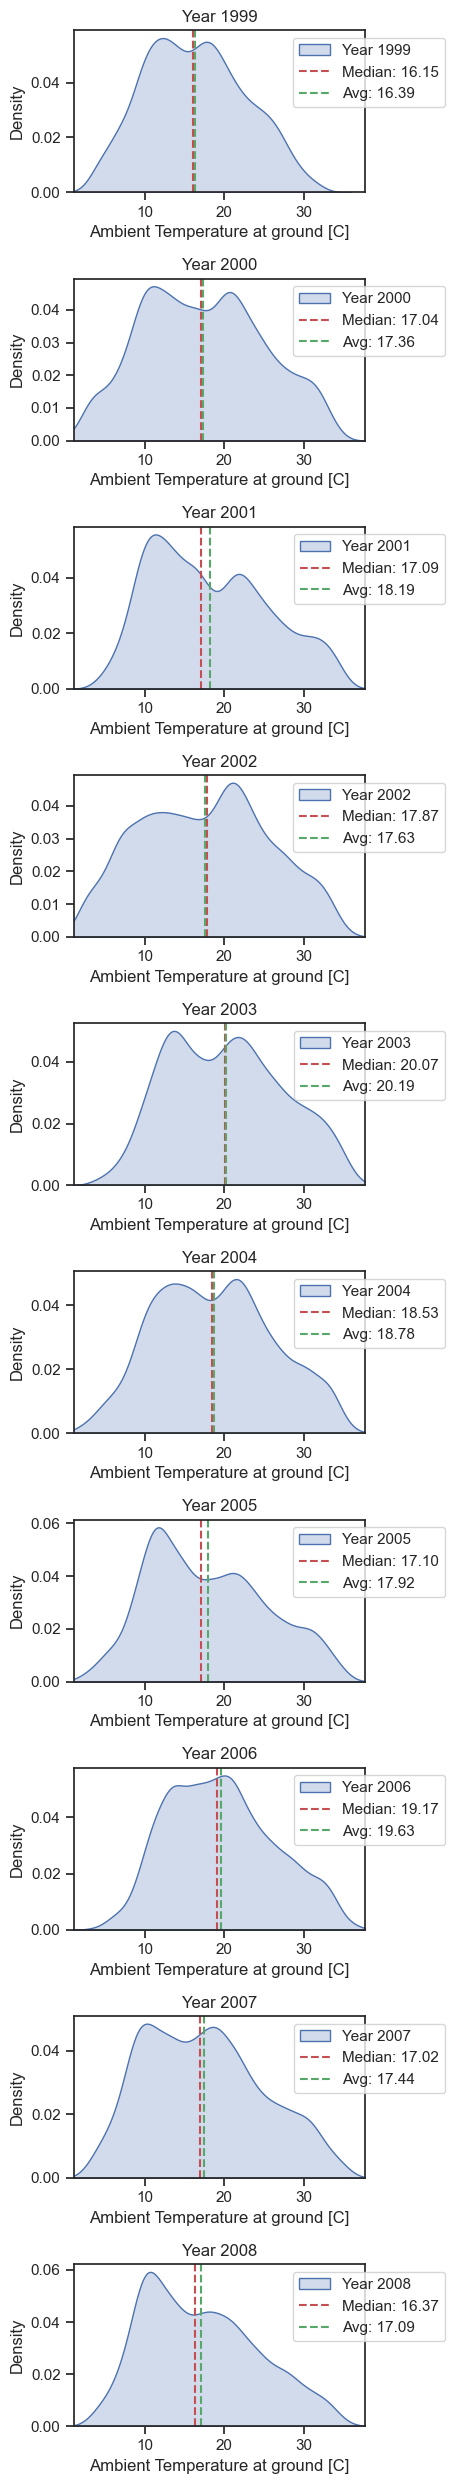

In [68]:
plot_density_by_year(df,'Ambient Temperature at ground [C]',folder = "../plots/histograms_per_year/",save = False )

this is an important variable, and has difference distributions through the years, probably if we want to use this dataset, we are going to have to clean some values, or apply transformations to specific years.

## Scatterplot

In [63]:
print('DF shape with nan values',df.shape)
print('DF shape without nan values',df.dropna().shape)

DF shape with nan values (78289, 12)
DF shape without nan values (73249, 12)


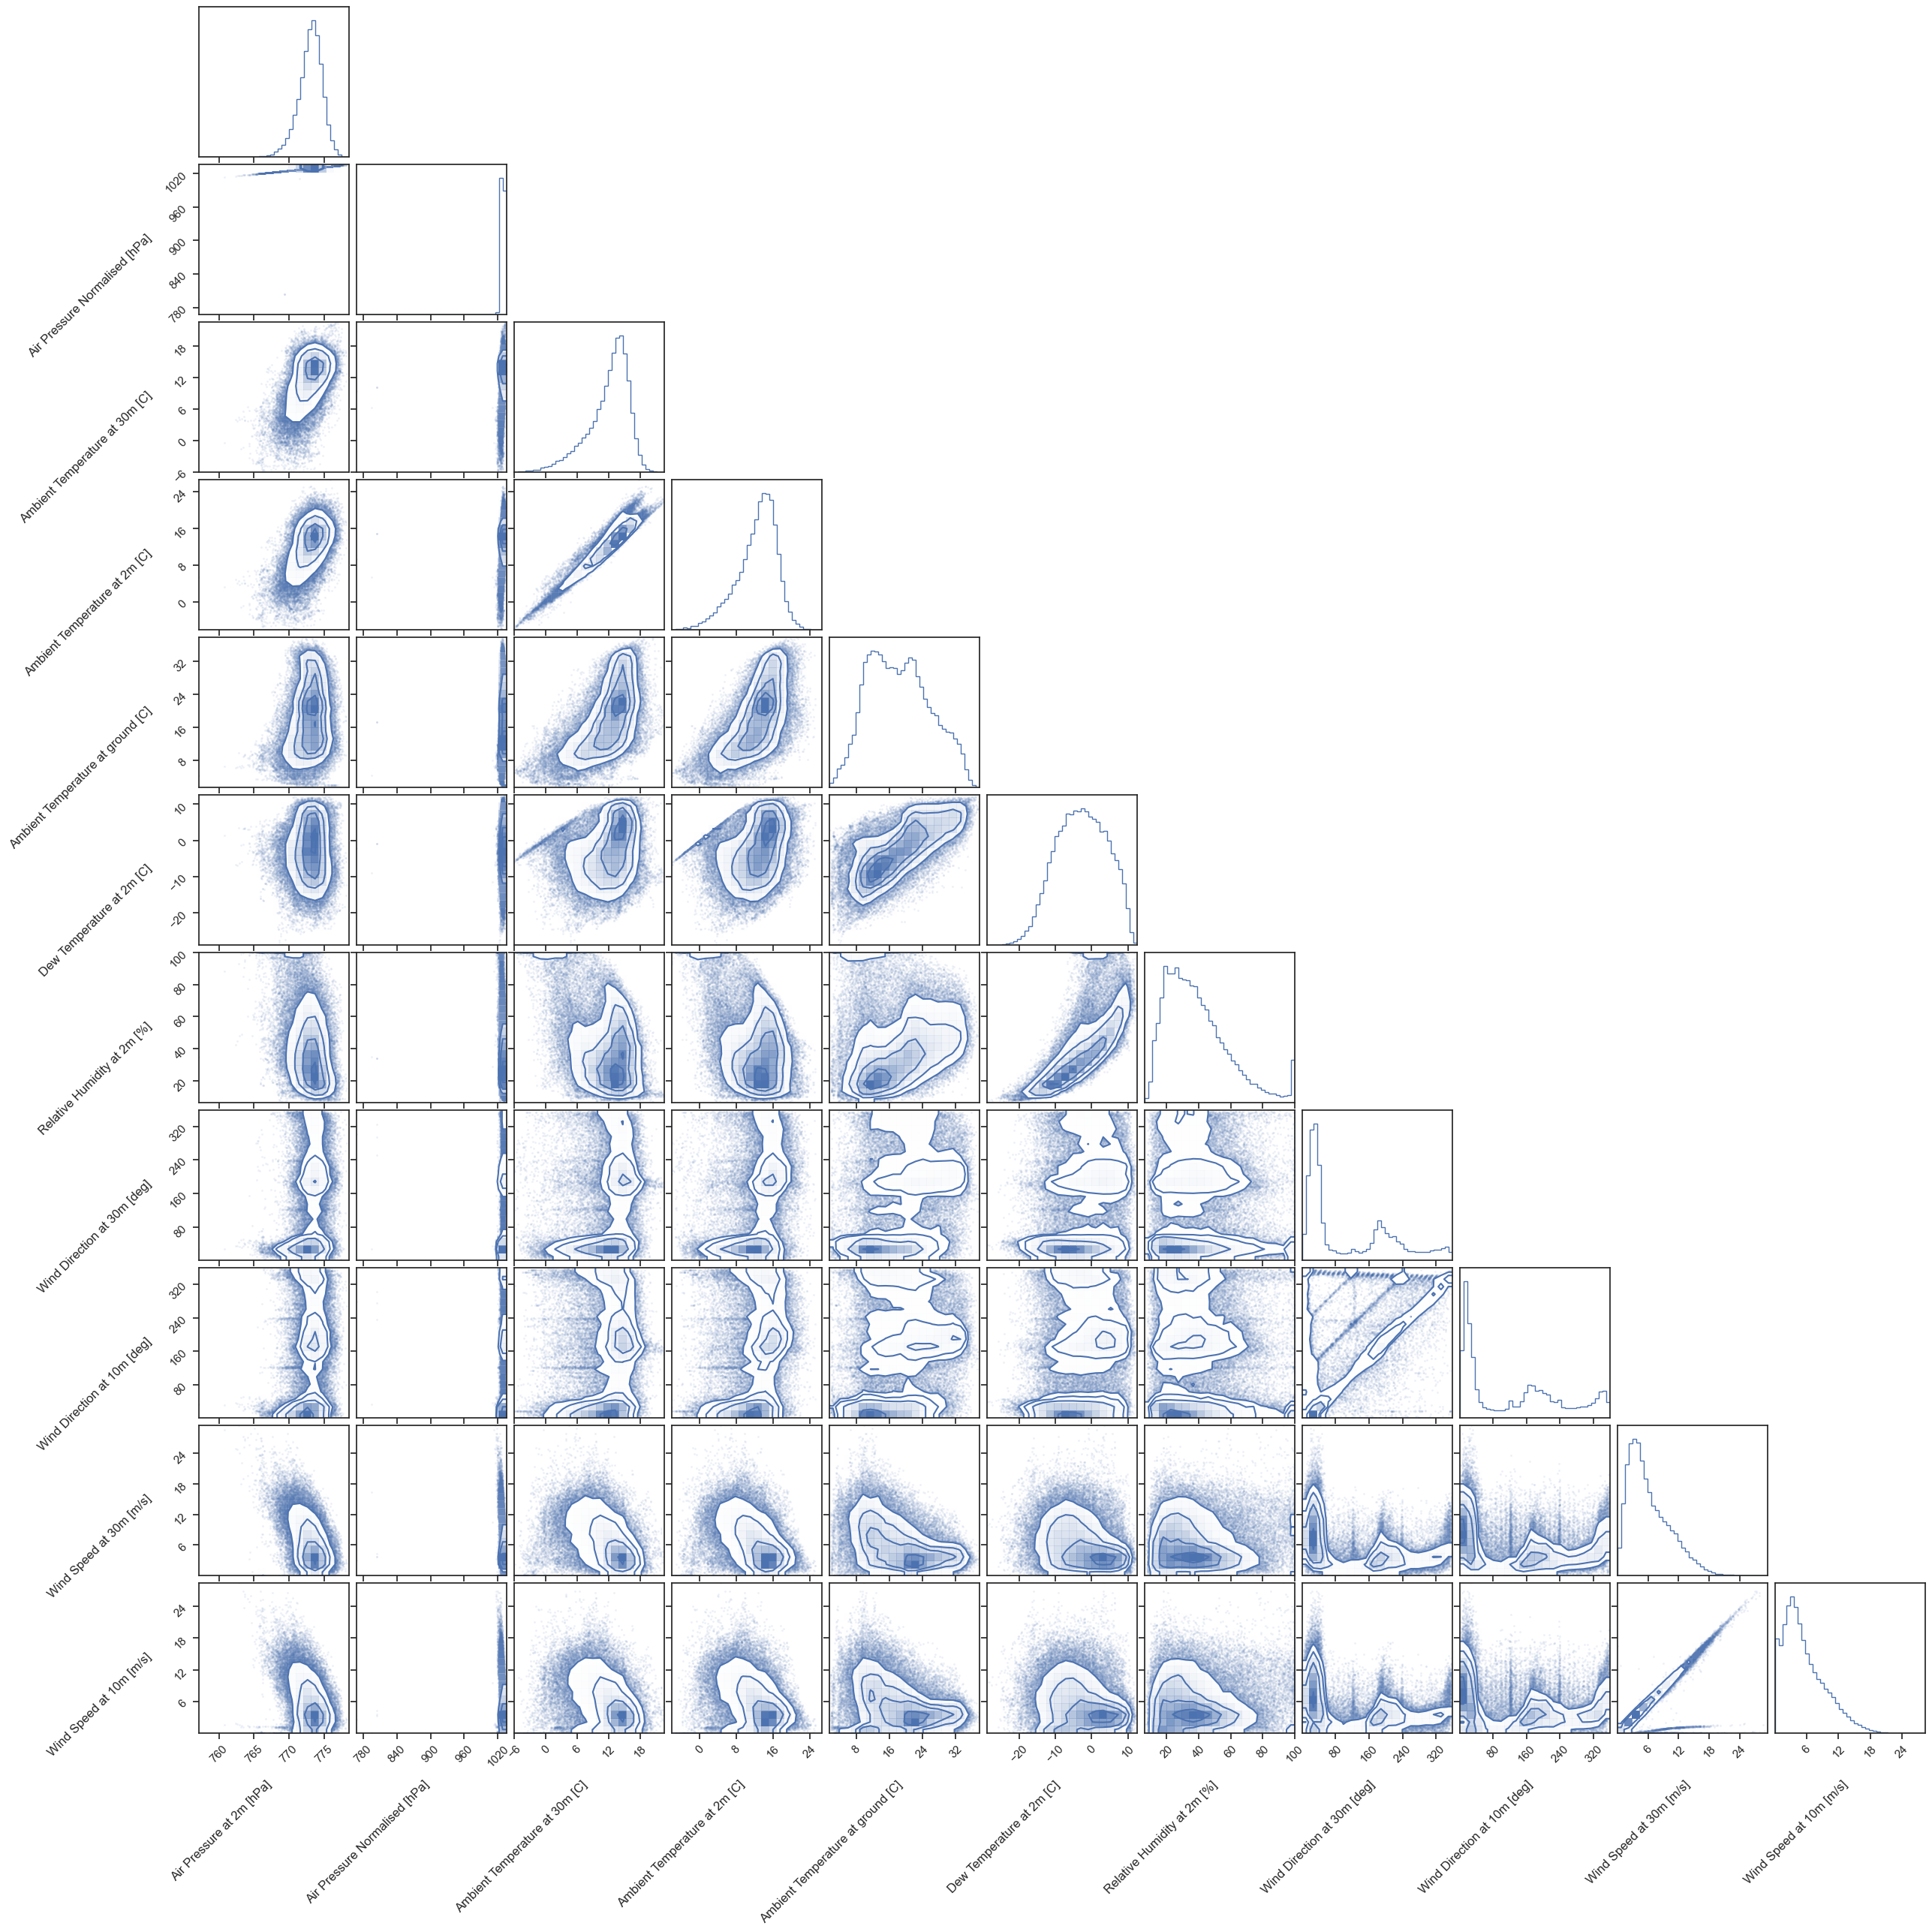

In [88]:
import corner
corner_plot = corner.corner(df.dropna().drop(columns=['year'],axis=1),
                             color='b', hist_bin_factor=2,labels=df.columns,
                               label_kwargs={'rotation': 45, 'ha': 'right'})

* Humidity with dew temperature keeps same relations if we compared to paranal
* Dew temperature and ambient temperature shows a positive relation
* Ambient temperature with wind speed ar 30m a negative relation

## Time series subplots

In [69]:
def plot_roll_mean(df,moving_average,year,variable,variable_list_air):
        
        fig, ax = plt.subplots(figsize=(25, 5))
        df[df.year == year][variable].plot(style=".", color="0.5", ax=ax,label=variable)
        moving_average[moving_average.year == year][variable_list_air[0]].plot(ax=ax, linewidth=3, title="",linestyle="-",color = 'blue', label='Moving mean of '+variable_list_air[0])
        moving_average[moving_average.year == year][variable_list_air[1]].plot(ax=ax, linewidth=3, title="",linestyle="-",color = 'red', label='Moving mean of '+variable_list_air[1])
        moving_average[moving_average.year == year][variable_list_air[2]].plot(ax=ax, linewidth=3, title="",linestyle="-",color = 'green', label='Moving mean of '+variable_list_air[2])
        # df[variable].plot(style=".", color="0.5", ax=ax,label=variable)
        # moving_average['Air Temperature at 2m [C]'].plot(ax=ax, linewidth=3, title="",linestyle="-",color = 'red', label='Moving mean')
        plt.xlabel('Timestamp')
        plt.ylabel(variable)
        ax.legend()
        plt.show()

In [70]:
moving_average = df.rolling(
    window=400,       
    center=True,      
    min_periods=200,  # minimo puntos requeridos, sino retorna nan
).mean()     

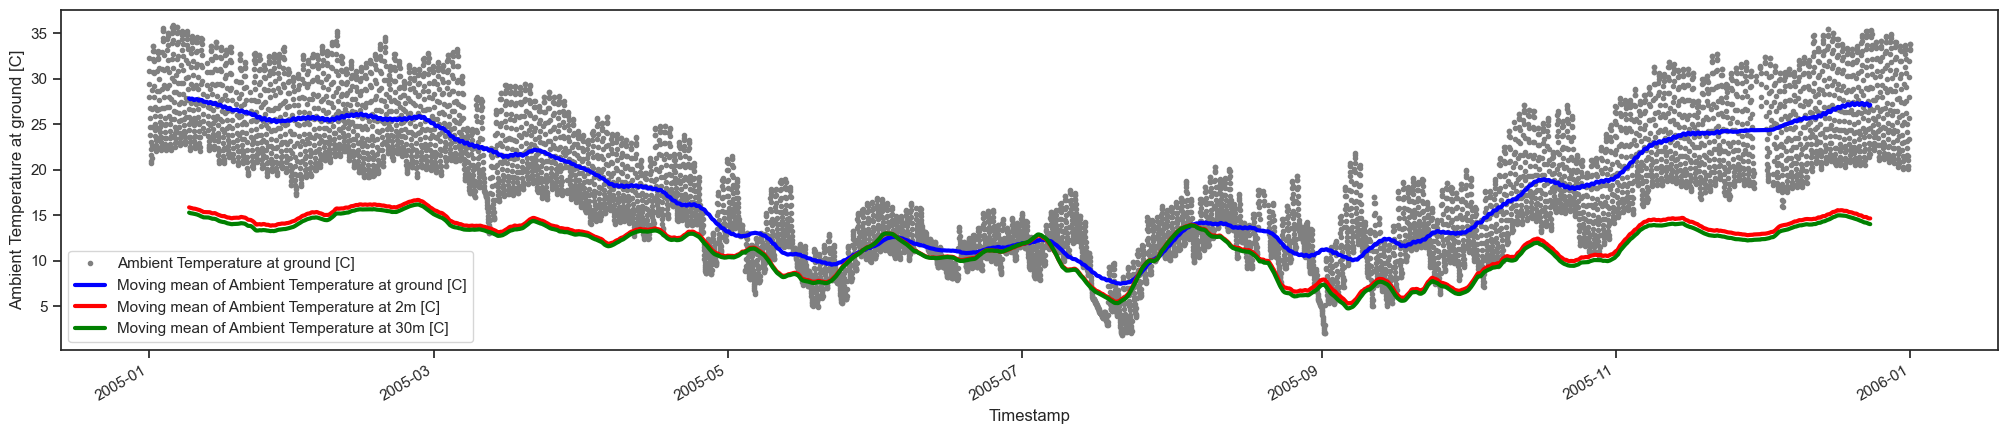

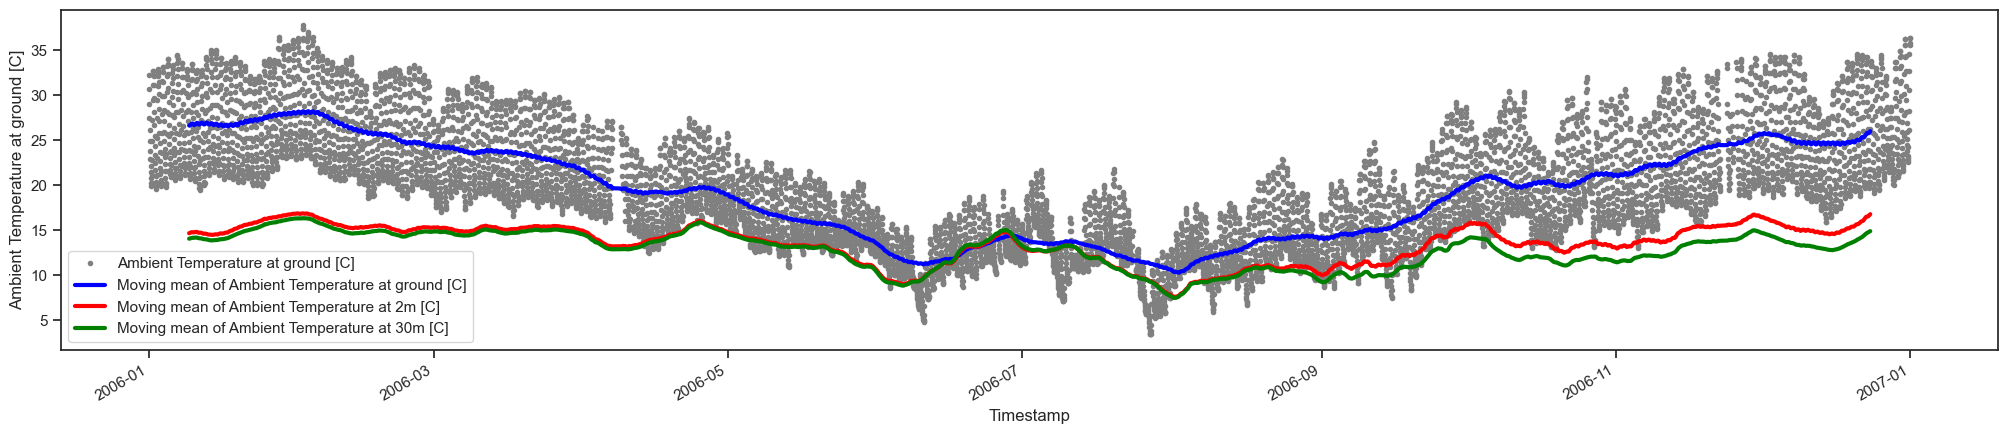

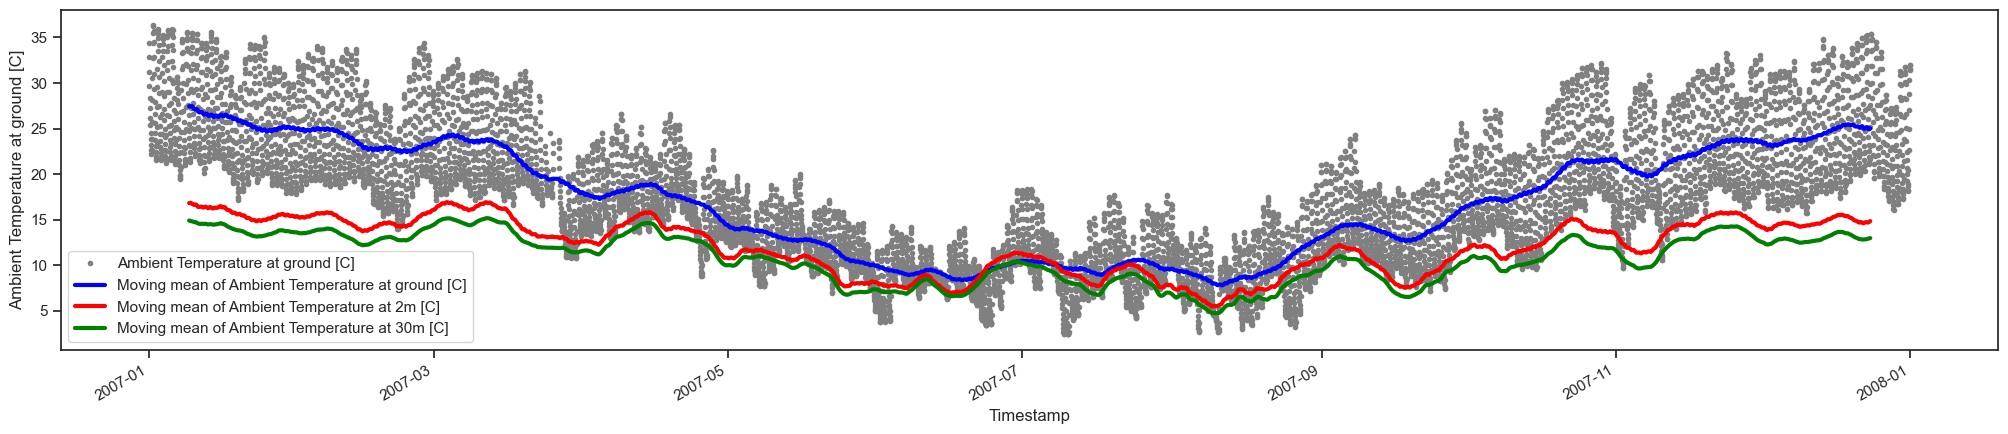

In [74]:
variable = 'Ambient Temperature at ground [C]'

variable_list_air =['Ambient Temperature at ground [C]',
'Ambient Temperature at 2m [C]',
'Ambient Temperature at 30m [C]'
]
for year in [2005,2006,2007]:
    plot_roll_mean(df,moving_average,year,variable,variable_list_air)

These plots has almost the same behavior, looks cool how the diferents levels of ambient temperature converges close to July. This is different against Paranal 

In [76]:
def plot_roll_mean2(df,moving_average,year,variable,variable2):
        
        fig, ax = plt.subplots(figsize=(25, 5))
        df[df.year == year][variable].plot(style=".", color="0.5", ax=ax,label=variable)
        moving_average[moving_average.year == year][variable2].plot(ax=ax, linewidth=3, title="",linestyle="-",color = 'blue', label='Moving mean of '+variable2)
        # df[variable].plot(style=".", color="0.5", ax=ax,label=variable)
        # moving_average['Air Temperature at 2m [C]'].plot(ax=ax, linewidth=3, title="",linestyle="-",color = 'red', label='Moving mean')
        plt.xlabel('Timestamp')
        plt.ylabel(variable)
        ax.legend()
        plt.show()

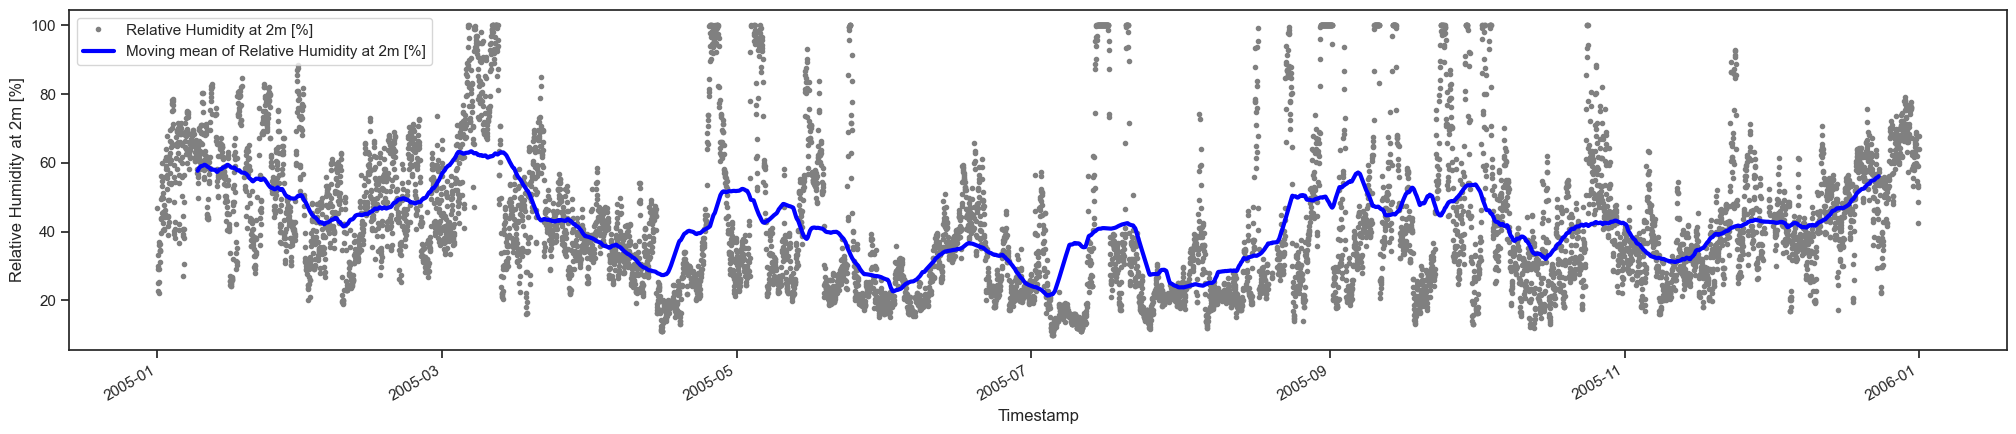

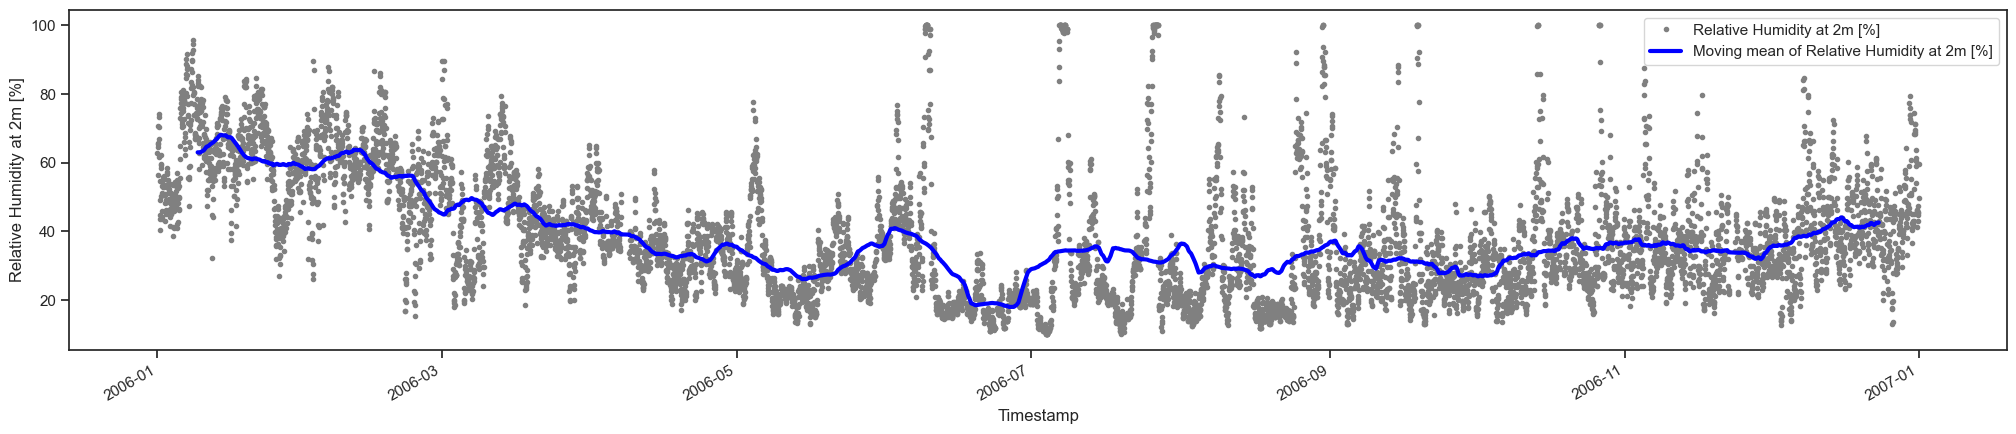

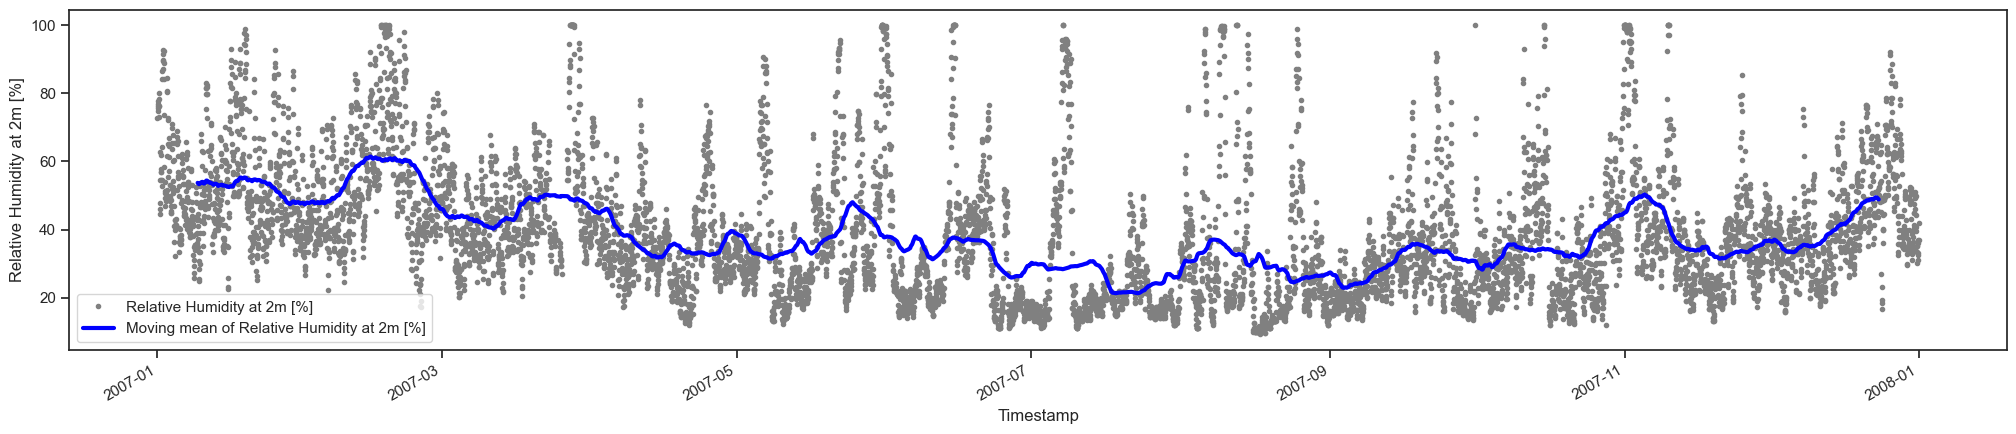

In [81]:
for year in [2005,2006,2007]:
    plot_roll_mean2(df,moving_average,year,'Relative Humidity at 2m [%]','Relative Humidity at 2m [%]')

Different behaviors, those plots in general tends to smaller values on winter, but still it has some peaks 